### ARIMA 모델(pmdarima)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error


In [2]:
# 데이터 로드
data = pd.read_csv('AirPassengers.csv', parse_dates=['Month'], index_col='Month')
data = data['#Passengers']
  # 승객 수 데이터를 로드하고, 날짜를 인덱스로 설정

In [3]:
data.head()

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64

In [4]:
# 데이터 나누기
train = data[:'1959']  # 1959년까지의 데이터를 사용하여 모델이 과거의 패턴을 학습
test = data['1960':] # 학습된 모델이 1960년 이후의 데이터를 얼마나 잘 예측하는지 평가

In [5]:
train.head()

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64

In [6]:
test.head()

Month
1960-01-01    417
1960-02-01    391
1960-03-01    419
1960-04-01    461
1960-05-01    472
Name: #Passengers, dtype: int64

### ARIMA
- 비계절성 시계열 데이터 분석에 적합한 방법론.
- 'AirPassengers' 데이터셋을 사용하여 항공 승객 수의 변동 예측

In [7]:
# ARIMA 모델 학습
model = ARIMA(train, order=(5,1,2))  # AR 항 5개, 차분 1회, MA 항 2개
model_fit = model.fit()

# AR(Autoregressive): 과거 값들이 현재 값을 설명하는데 사용
# I(Integrated): 차분 데이터를 안정화하기 위해 사용합
# MA(Moving Average): 과거 예측 오차를 사용하여 현재 값을 설명.


/home/tommy/anaconda3/envs/p311/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/tommy/anaconda3/envs/p311/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/tommy/anaconda3/envs/p311/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [8]:
# 예측
predictions = model_fit.forecast(steps=len(test))

In [9]:
# 모델 평가
mse = mean_squared_error(test, predictions)
print(f'Mean Squared Error: {mse}')  # 7842.463397690625   .... 88



Mean Squared Error: 7842.463397690625


In [10]:
import math
math.sqrt(mse)

88.55768401268534

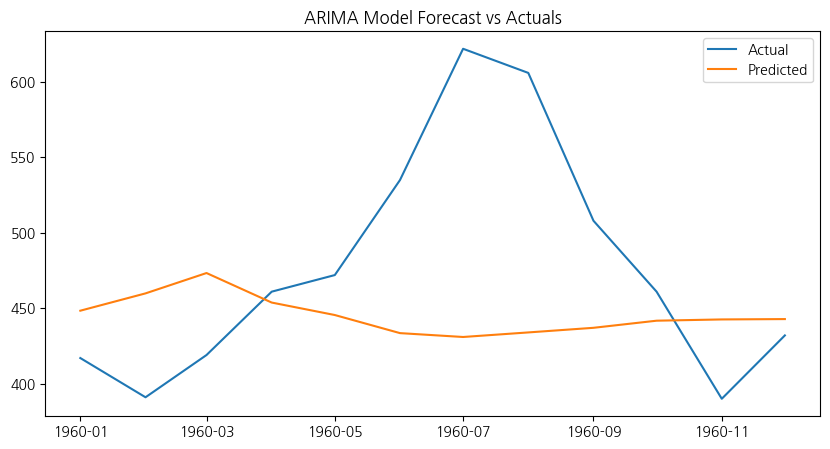

In [11]:
# 시각화
plt.figure(figsize=(10,5))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, predictions, label='Predicted')
plt.title('ARIMA Model Forecast vs Actuals')
plt.legend()
plt.show()


### RNN 모델

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense


2024-11-04 09:31:47.325603: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730680307.464066    5899 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730680307.505418    5899 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-04 09:31:47.841867: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
# 데이터 로드 및 스케일링
data = pd.read_csv('AirPassengers.csv', parse_dates=['Month'], index_col='Month')
scaler = MinMaxScaler()   # MinMaxScaler 객체를 생성, 0과 1 사이의 값으로 변환
data_scaled = scaler.fit_transform(data)  # 데이터 스케일링



In [14]:
# 데이터 분할
# 시계열 데이터를 입력 및 타겟 데이터로 변환
def create_dataset(data, look_back=1):  # look_back : 과거 몇 개의 데이터를 기반으로 다음 값을 예측할지 결정 -> 시퀀스 생성
    X, Y = [], []  # X : 입력데이터 저장, Y : 입력에 대한 타겟(정답) 데이터 저장, X에 해당하는 시퀀스 다음에 오는 단일 데이터 포인트
    for i in range(len(data)-look_back): # len(data)-look_back 만큼 반복문 실행 <- look_back 값을 사용하여 데이터의 끝까지 루프
        X.append(data[i:(i+look_back), 0])  # 현재 인덱스 i에서 시작하여 i+look_back까지의 데이터를 X 리스트에 추가
        Y.append(data[i + look_back, 0])    # i + look_back 위치의 데이터 (즉, X의 마지막 데이터 다음 시점의 데이터)를 Y 리스트에 추가
    return np.array(X), np.array(Y)  # X와 Y를 NumPy 배열로 변환하여 반환


In [15]:
look_back = 10    # 과거 몇 개의 데이터를 기반으로 다음 값을 예측할지 결정

X, Y = create_dataset(data_scaled)
train_size = int(len(X) * 0.67)  # 전체 데이터의 67%를 학습용 데이터로 설정
test_size = len(X) - train_size  #  33%를 테스트용 데이터로 설정

X_train, X_test = X[0:train_size], X[train_size:len(X)]  # X 데이터의 처음부터 train_size까지의 데이터를 학습용 데이터로 설정
Y_train, Y_test = Y[0:train_size], Y[train_size:len(Y)]

In [16]:
X_train.shape

(95, 1)

In [17]:
print(X[:5])


[[0.01544402]
 [0.02702703]
 [0.05405405]
 [0.04826255]
 [0.03281853]]


In [18]:
# RNN 모델 구축
# SimpleRNN 층을 사용한 간단한 RNN 모델 구축
look_back = 1
model = Sequential()
model.add(SimpleRNN(4, input_shape=(1, look_back)))  # look_back: 입력 시퀀스의 길이(과거 데이터를 몇 개 볼 것인지).
                                                     # 1: 각 타임스텝에서 입력 피처의 수. 여기서는 단일 피처(스칼라 값)를 입력으로 사용
model.add(Dense(1))

I0000 00:00:1730680311.142257    5899 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9711 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:07:00.0, compute capability: 8.6
/home/tommy/anaconda3/envs/p311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 4)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29 (116.00 B)

 Trainable params: 29 (116.00 B)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, Y_train, epochs=50, batch_size=1, verbose=2)



Epoch 1/50


I0000 00:00:1730680313.212700    5970 service.cc:148] XLA service 0x7f14c4003470 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730680313.212973    5970 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-11-04 09:31:53.262559: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1730680313.381930    5970 cuda_dnn.cc:529] Loaded cuDNN version 90300


95/95 - 1s - 14ms/step - loss: 0.0926
Epoch 2/50


I0000 00:00:1730680313.637844    5970 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


95/95 - 0s - 1ms/step - loss: 0.0388
Epoch 3/50
95/95 - 0s - 1ms/step - loss: 0.0328
Epoch 4/50
95/95 - 0s - 1ms/step - loss: 0.0284
Epoch 5/50
95/95 - 0s - 1ms/step - loss: 0.0244
Epoch 6/50
95/95 - 0s - 1ms/step - loss: 0.0209
Epoch 7/50
95/95 - 0s - 1ms/step - loss: 0.0178
Epoch 8/50
95/95 - 0s - 1ms/step - loss: 0.0153
Epoch 9/50
95/95 - 0s - 1ms/step - loss: 0.0130
Epoch 10/50
95/95 - 0s - 1ms/step - loss: 0.0111
Epoch 11/50
95/95 - 0s - 1ms/step - loss: 0.0096
Epoch 12/50
95/95 - 0s - 1ms/step - loss: 0.0079
Epoch 13/50
95/95 - 0s - 1ms/step - loss: 0.0066
Epoch 14/50
95/95 - 0s - 1ms/step - loss: 0.0056
Epoch 15/50
95/95 - 0s - 1ms/step - loss: 0.0047
Epoch 16/50
95/95 - 0s - 1ms/step - loss: 0.0040
Epoch 17/50
95/95 - 0s - 1ms/step - loss: 0.0035
Epoch 18/50
95/95 - 0s - 1ms/step - loss: 0.0030
Epoch 19/50
95/95 - 0s - 1ms/step - loss: 0.0027
Epoch 20/50
95/95 - 0s - 1ms/step - loss: 0.0024
Epoch 21/50
95/95 - 0s - 1ms/step - loss: 0.0023
Epoch 22/50
95/95 - 0s - 1ms/step - los

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


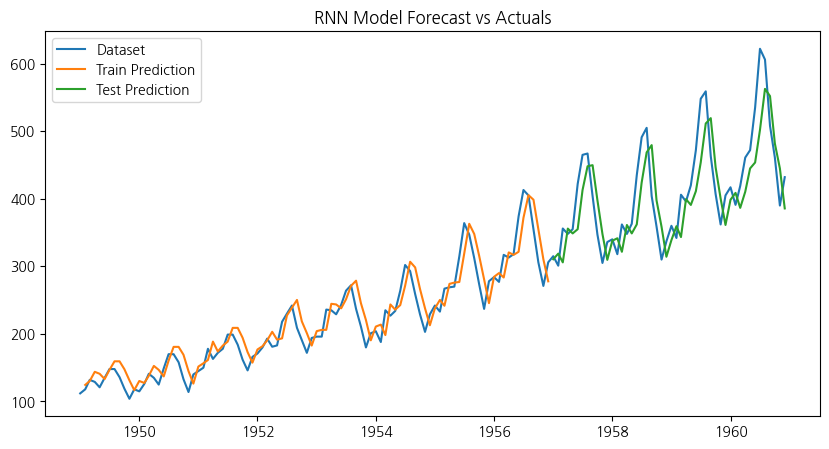

In [21]:
# 예측 및 시각화
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform([Y_test])

plt.figure(figsize=(10,5))
plt.plot(data.index, scaler.inverse_transform(data_scaled), label='Dataset')
plt.plot(data.index[look_back:len(train_predict)+look_back], train_predict, label='Train Prediction')
# Adjust the slicing of data.index to match the length of test_predict
plt.plot(data.index[len(train_predict)+look_back:len(data)], test_predict.flatten(), label='Test Prediction')
plt.title('RNN Model Forecast vs Actuals')
plt.legend()
plt.show()

In [22]:
# 모델 평가
train_mse = mean_squared_error(scaler.inverse_transform([Y_train])[0], train_predict[:,0])
test_mse = mean_squared_error(test_actual[0], test_predict[:,0])
print(f'Train MSE: {train_mse:.2f}')
print(f'Test MSE: {test_mse:.2f}')  #  7429.07 .... 86.

Train MSE: 563.50
Test MSE: 2196.48


In [23]:
math.sqrt(test_mse)

46.866581833049686

### LSTM 모델

In [24]:
from tensorflow.keras.layers import LSTM

# LSTM 모델 구축
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, Y_train, epochs=50, batch_size=1, verbose=2)

# verbose : Keras 모델의 fit 메서드에서 학습 과정 중에 출력되는 로그의 상세도
  # verbose=0: 학습 과정 중에 아무런 출력 없음
  # verbose=1: 학습의 진행 상황을 보여주는 progress bar 출력합니다. 각 에포크(epoch)가 완료될 때마다 업데이ㅌ,.
  # verbose=2: 각 에포크마다 로그 정보 출력. 각 에포크마다 손실 값과 평가 지표가 출력

Epoch 1/50


/home/tommy/anaconda3/envs/p311/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


95/95 - 2s - 19ms/step - loss: 0.0405
Epoch 2/50
95/95 - 1s - 6ms/step - loss: 0.0184
Epoch 3/50
95/95 - 1s - 6ms/step - loss: 0.0140
Epoch 4/50
95/95 - 1s - 6ms/step - loss: 0.0128
Epoch 5/50
95/95 - 0s - 5ms/step - loss: 0.0117
Epoch 6/50
95/95 - 0s - 5ms/step - loss: 0.0107
Epoch 7/50
95/95 - 1s - 6ms/step - loss: 0.0097
Epoch 8/50
95/95 - 1s - 6ms/step - loss: 0.0088
Epoch 9/50
95/95 - 1s - 6ms/step - loss: 0.0079
Epoch 10/50
95/95 - 1s - 6ms/step - loss: 0.0070
Epoch 11/50
95/95 - 1s - 6ms/step - loss: 0.0062
Epoch 12/50
95/95 - 1s - 6ms/step - loss: 0.0054
Epoch 13/50
95/95 - 1s - 6ms/step - loss: 0.0048
Epoch 14/50
95/95 - 1s - 6ms/step - loss: 0.0042
Epoch 15/50
95/95 - 1s - 6ms/step - loss: 0.0037
Epoch 16/50
95/95 - 1s - 6ms/step - loss: 0.0033
Epoch 17/50
95/95 - 1s - 6ms/step - loss: 0.0029
Epoch 18/50
95/95 - 0s - 5ms/step - loss: 0.0027
Epoch 19/50
95/95 - 0s - 5ms/step - loss: 0.0025
Epoch 20/50
95/95 - 1s - 6ms/step - loss: 0.0023
Epoch 21/50
95/95 - 1s - 6ms/step - los

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


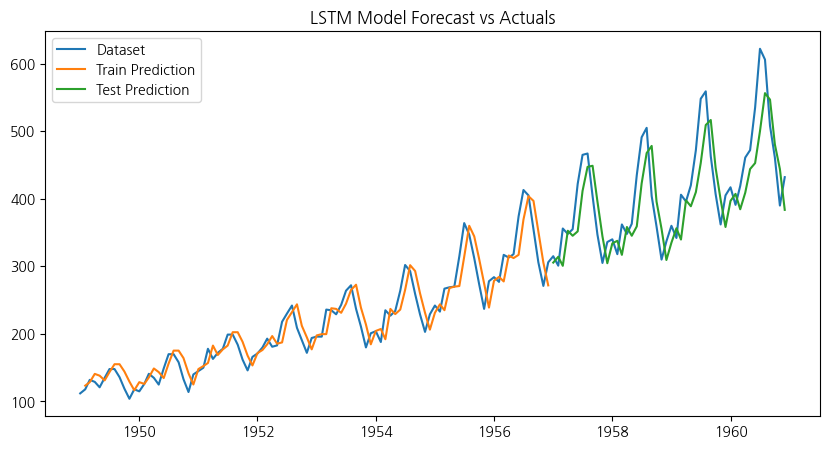

In [25]:
# LSTM 예측 및 시각화
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
test_actual = scaler.inverse_transform([Y_test])

plt.figure(figsize=(10,5))
plt.plot(data.index, scaler.inverse_transform(data_scaled), label='Dataset')
plt.plot(data.index[look_back:len(train_predict)+look_back], train_predict, label='Train Prediction')

# Calculate the correct start index for test predictions, subtracting 1 to align with the test set
start_index_test = len(train_predict) + (look_back * 2) - 1
# The end index remains the same, ensuring it covers the entire test set
end_index_test = len(data)

# Use the corrected indices to slice data.index
plt.plot(data.index[start_index_test:end_index_test], test_predict.flatten(), label='Test Prediction')
plt.title('LSTM Model Forecast vs Actuals')
plt.legend()
plt.show()

In [26]:
# 모델 평가
train_mse = mean_squared_error(scaler.inverse_transform([Y_train])[0], train_predict[:,0])
test_mse = mean_squared_error(test_actual[0], test_predict[:,0])
print(f'Train MSE: {train_mse:.2f}')
print(f'Test MSE: {test_mse:.2f}')  #  2221.62 .... 41.

Train MSE: 527.83
Test MSE: 2271.68


In [27]:
math.sqrt(test_mse)

47.66209585435155

In [28]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [29]:
# 데이터 로드
data = pd.read_csv('AirPassengers.csv', index_col='Month', parse_dates=True)

In [30]:
# 로그 변환
data_log = np.log(data)

In [31]:
# 데이터 분할
train_log = data_log[:'1959']
test_log = data_log['1960':]

In [32]:

# Auto-ARIMA 모델 학습
model_auto = auto_arima(train_log, seasonal=True, m=12)
model_auto_fit = model_auto.fit(train_log)


In [33]:

# 예측 수행
predictions_log = model_auto_fit.predict(n_periods=len(test_log))
predictions_log = pd.Series(predictions_log, index=test_log.index)


In [34]:
# 로그 변환 복원
predictions = np.exp(predictions_log)
test = np.exp(test_log)



In [35]:
# 성능 평가
mse = mean_squared_error(test, predictions)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 531.7989178867386


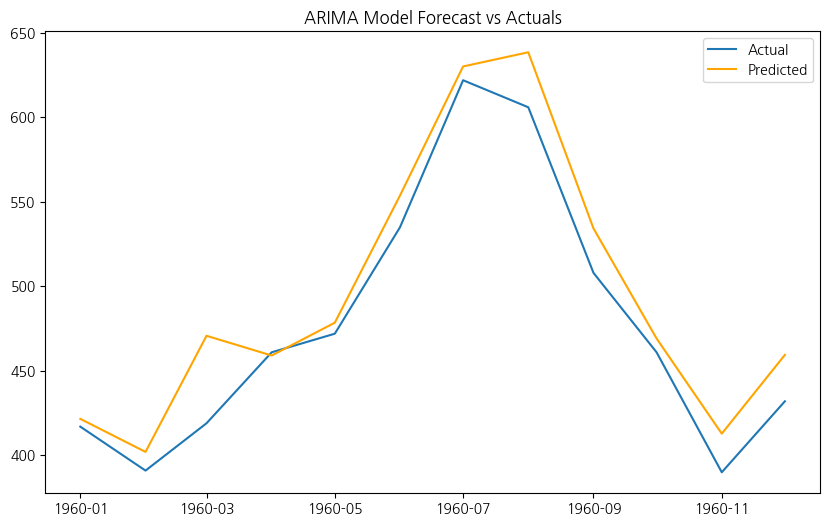

In [36]:

# 실제 값과 예측 값 시각화
plt.figure(figsize=(10, 6))
plt.plot(test, label='Actual')
plt.plot(predictions, label='Predicted', color='orange')
plt.title('ARIMA Model Forecast vs Actuals')
plt.legend()
plt.show()
